In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from PIL import Image
from io import BytesIO

In [41]:
torch.set_default_device("cuda")

In [42]:
class MnistDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_parquet(file_path)
        self.length = len(df)

        self.images = torch.zeros((self.length, 28 * 28), dtype=torch.float32)
        self.labels = torch.zeros((self.length, 10), dtype=torch.float32)

        for i, entry in df.iterrows():
            with Image.open(BytesIO(entry["image.bytes"])) as img:
                img_gray = img.convert("L")
                pixel_array = np.array(img_gray)
                flattened_array = pixel_array.flatten()
                normalized_array = flattened_array / 255.0
                self.images[i, :] = torch.tensor(normalized_array, dtype=torch.float32)

            self.labels[i, entry["label"]] = 1.0

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.images[index], self.labels[index]


train_set = MnistDataset("train.parquet")
test_set = MnistDataset("test.parquet")

BATCH_SIZE = 32
dataloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE)

In [43]:
class MultiLayerNN(nn.Module):
    def __init__(self, input_size, hidden_layer_count, hidden_size, output_size):
        super(MultiLayerNN, self).__init__()

        if hidden_layer_count == 0:
            self.input_layer = nn.Linear(input_size, output_size)
            self.layers = []
        else:
            self.input_layer = nn.Linear(input_size, hidden_size)
            self.layers = []
            for i in range(hidden_layer_count):
                self.layers.append(
                    nn.Linear(
                        hidden_size,
                        output_size if i == hidden_layer_count - 1 else hidden_size,
                    )
                )

    def forward(self, x):
        interm = self.input_layer(x)

        for i, layer in enumerate(self.layers):
            new_pass = layer(interm)

            if i < len(self.layers) - 1:
                interm = nn.functional.relu(new_pass)
            else:
                interm = new_pass

        return interm

In [44]:
INPUT_DIMENSION = 28 * 28
OUTPUT_DIMENSION = 10

HIDDEN_LAYER_COUNT = 2
HIDDEN_LAYER_SIZE = 30

model = MultiLayerNN(
    INPUT_DIMENSION, HIDDEN_LAYER_COUNT, HIDDEN_LAYER_SIZE, OUTPUT_DIMENSION
).to("cuda")
model.train()

MultiLayerNN(
  (input_layer): Linear(in_features=784, out_features=30, bias=True)
)

In [45]:
loss_fun = nn.MSELoss()

In [46]:
LEARNING_RATE = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [47]:
NUM_EPOCHS = 500

losses = torch.zeros(NUM_EPOCHS)

for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.float().to("cuda")
        labels = labels.float().to("cuda")

        optimizer.zero_grad()
        pred = model(inputs)

        # compute loss
        loss = loss_fun(pred, labels)

        # backprop
        loss.backward()

        # update weights
        optimizer.step()

    losses[epoch] = loss.item()

<Axes: >

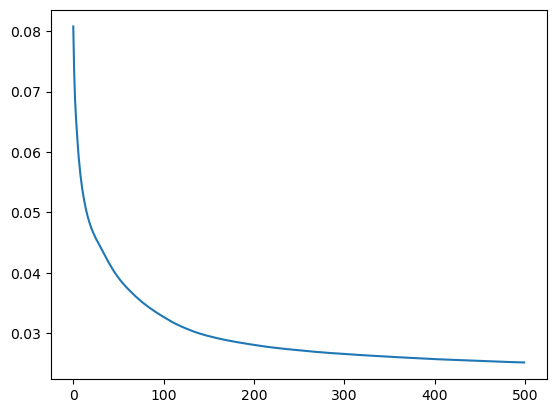

In [48]:
# Plot loss over time
sns.lineplot(x=range(len(losses)), y=losses.cpu())

In [49]:
model.eval()

correct = 0
total = 0

for i, data in enumerate(test_set):
    output = model(torch.tensor(data[0]))
    total += 1
    if torch.argmax(output) == torch.argmax(data[1]):
        correct += 1

error_rate = 1 - correct / total
print(f"Error rate in percent: {error_rate * 100}%")

c:\Users\leodr\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Error rate in percent: 10.229999999999995%
